# 修復 Thermal-RGB 對齊問題
## 問題 1: 左右翻轉 | 問題 2: 少數配對錯誤

In [1]:
import json
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ Libraries loaded")

✓ Libraries loaded


## Step 1: 檢查並修復左右翻轉問題

In [2]:
# 設定路徑
SYNCHRONIZED_DIR = Path('./output/synchronized')
FIXED_DIR = Path('./output/synchronized_fixed')
FIXED_DIR.mkdir(parents=True, exist_ok=True)

(FIXED_DIR / 'thermal').mkdir(exist_ok=True)
(FIXED_DIR / 'rgb').mkdir(exist_ok=True)

print(f"原始資料: {SYNCHRONIZED_DIR}")
print(f"修復後: {FIXED_DIR}")

原始資料: output/synchronized
修復後: output/synchronized_fixed


總配對數: 661

檢查前 3 個配對，判斷是否需要翻轉...


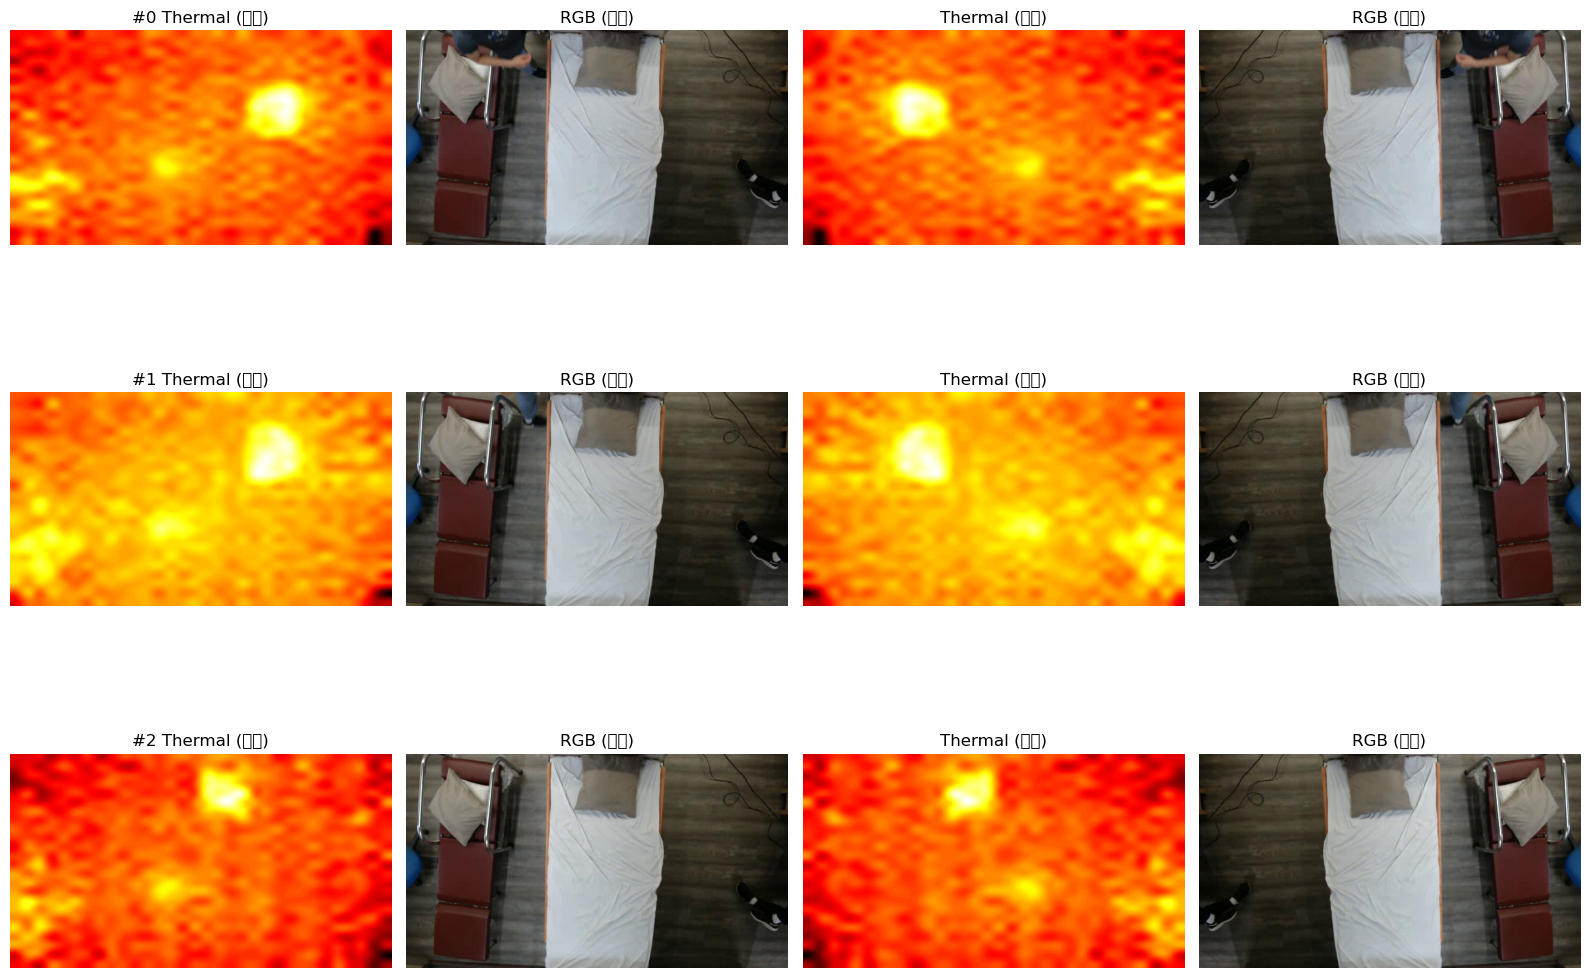


✓ 翻轉比較圖已存至: output/synchronized_fixed/flip_comparison.png

請查看上圖，判斷:
  選項 A: 原始的就對（左邊兩欄匹配）
  選項 B: 需要翻轉 Thermal（右邊 Thermal翻轉 vs RGB原始 匹配）
  選項 C: 需要翻轉 RGB（左邊 Thermal原始 vs RGB翻轉 不在圖中，需手動判斷）
  選項 D: 兩者都要翻轉（右邊兩欄匹配）


In [3]:
# 載入 metadata
meta_df = pd.read_csv(SYNCHRONIZED_DIR / 'metadata.csv')
print(f"總配對數: {len(meta_df)}")

# 檢查幾個樣本，確認翻轉方向
print("\n檢查前 3 個配對，判斷是否需要翻轉...")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(3):
    row = meta_df.iloc[i]
    pair_id = row['pair_id']
    
    # 載入原始圖片
    thermal = np.load(SYNCHRONIZED_DIR / 'thermal' / f"{pair_id}_thermal.npy")
    rgb = np.load(SYNCHRONIZED_DIR / 'rgb' / f"{pair_id}_rgb.npy")
    
    # 放大 thermal
    thermal_up = cv2.resize(thermal, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # 水平翻轉
    thermal_flip = cv2.flip(thermal_up, 1)  # 1 = 水平翻轉
    rgb_flip = cv2.flip(rgb, 1)
    
    # 顯示原始
    axes[i, 0].imshow(thermal_up, cmap='hot')
    axes[i, 0].set_title(f'#{i} Thermal (原始)')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(rgb)
    axes[i, 1].set_title(f'RGB (原始)')
    axes[i, 1].axis('off')
    
    # 顯示翻轉後
    axes[i, 2].imshow(thermal_flip, cmap='hot')
    axes[i, 2].set_title(f'Thermal (翻轉)')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(rgb_flip)
    axes[i, 3].set_title(f'RGB (翻轉)')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig(FIXED_DIR / 'flip_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 翻轉比較圖已存至: {FIXED_DIR / 'flip_comparison.png'}")
print("\n請查看上圖，判斷:")
print("  選項 A: 原始的就對（左邊兩欄匹配）")
print("  選項 B: 需要翻轉 Thermal（右邊 Thermal翻轉 vs RGB原始 匹配）")
print("  選項 C: 需要翻轉 RGB（左邊 Thermal原始 vs RGB翻轉 不在圖中，需手動判斷）")
print("  選項 D: 兩者都要翻轉（右邊兩欄匹配）")

In [4]:
# ========== 請在這裡設定翻轉選項 ==========
FLIP_THERMAL = True   # 如果 Thermal 需要水平翻轉，設為 True
FLIP_RGB = False      # 如果 RGB 需要水平翻轉，設為 True
# ==========================================

print(f"翻轉設定:")
print(f"  Thermal 翻轉: {FLIP_THERMAL}")
print(f"  RGB 翻轉: {FLIP_RGB}")

翻轉設定:
  Thermal 翻轉: True
  RGB 翻轉: False


## Step 2: 分析配對錯誤（例如 #94）

In [5]:
# 檢查 #94 附近的配對
print("檢查 #94 附近的配對資訊...\n")

check_range = range(max(0, 94-5), min(len(meta_df), 94+6))

for i in check_range:
    row = meta_df.iloc[i]
    print(f"\n配對 #{i}:")
    print(f"  Timestamp: {row['timestamp']}")
    print(f"  RGB Frame Index: {row['rgb_frame_idx']}")
    print(f"  Thermal Error: {row['thermal_error_ms']:.2f}ms")
    print(f"  RGB Error: {row['rgb_error_ms']:.2f}ms")

# 計算 RGB 幀索引的跳躍
rgb_indices = meta_df['rgb_frame_idx'].values
rgb_diffs = np.diff(rgb_indices)

print("\n" + "="*70)
print("RGB 幀跳躍分析")
print("="*70)
print(f"平均幀間隔: {rgb_diffs.mean():.2f}")
print(f"標準差: {rgb_diffs.std():.2f}")

# 找出異常跳躍
threshold = rgb_diffs.mean() + 2 * rgb_diffs.std()
large_jumps = np.where(rgb_diffs > threshold)[0]

if len(large_jumps) > 0:
    print(f"\n⚠️ 發現 {len(large_jumps)} 個異常大跳躍:")
    for idx in large_jumps[:20]:
        print(f"  #{idx} -> #{idx+1}: 幀 {rgb_indices[idx]} -> {rgb_indices[idx+1]} (跳了 {rgb_diffs[idx]} 幀)")
        if idx == 94 or idx == 93:
            print(f"    ⚠️ 這就是 #94 的問題！")

# 檢查是否有重複的 RGB 幀
duplicates = np.where(rgb_diffs == 0)[0]
if len(duplicates) > 0:
    print(f"\n⚠️ 發現 {len(duplicates)} 個重複的 RGB 幀:")
    for idx in duplicates[:10]:
        print(f"  #{idx} 和 #{idx+1} 使用相同的 RGB 幀 {rgb_indices[idx]}")

檢查 #94 附近的配對資訊...


配對 #89:
  Timestamp: 2020-09-24 13:10:59.268
  RGB Frame Index: 2195
  Thermal Error: 0.00ms
  RGB Error: 25.54ms

配對 #90:
  Timestamp: 2020-09-24 13:11:00.268
  RGB Frame Index: 2220
  Thermal Error: 0.00ms
  RGB Error: 12.16ms

配對 #91:
  Timestamp: 2020-09-24 13:11:01.268
  RGB Frame Index: 2244
  Thermal Error: 0.00ms
  RGB Error: 39.32ms

配對 #92:
  Timestamp: 2020-09-24 13:11:02.268
  RGB Frame Index: 2269
  Thermal Error: 0.00ms
  RGB Error: 25.94ms

配對 #93:
  Timestamp: 2020-09-24 13:11:03.268
  RGB Frame Index: 2294
  Thermal Error: 0.00ms
  RGB Error: 12.57ms

配對 #94:
  Timestamp: 2020-09-24 13:11:04.268
  RGB Frame Index: 2318
  Thermal Error: 0.00ms
  RGB Error: 39.72ms

配對 #95:
  Timestamp: 2020-09-24 13:11:05.268
  RGB Frame Index: 2343
  Thermal Error: 0.00ms
  RGB Error: 26.35ms

配對 #96:
  Timestamp: 2020-09-24 13:11:06.268
  RGB Frame Index: 2368
  Thermal Error: 0.00ms
  RGB Error: 12.97ms

配對 #97:
  Timestamp: 2020-09-24 13:11:07.268
  RGB Frame Ind

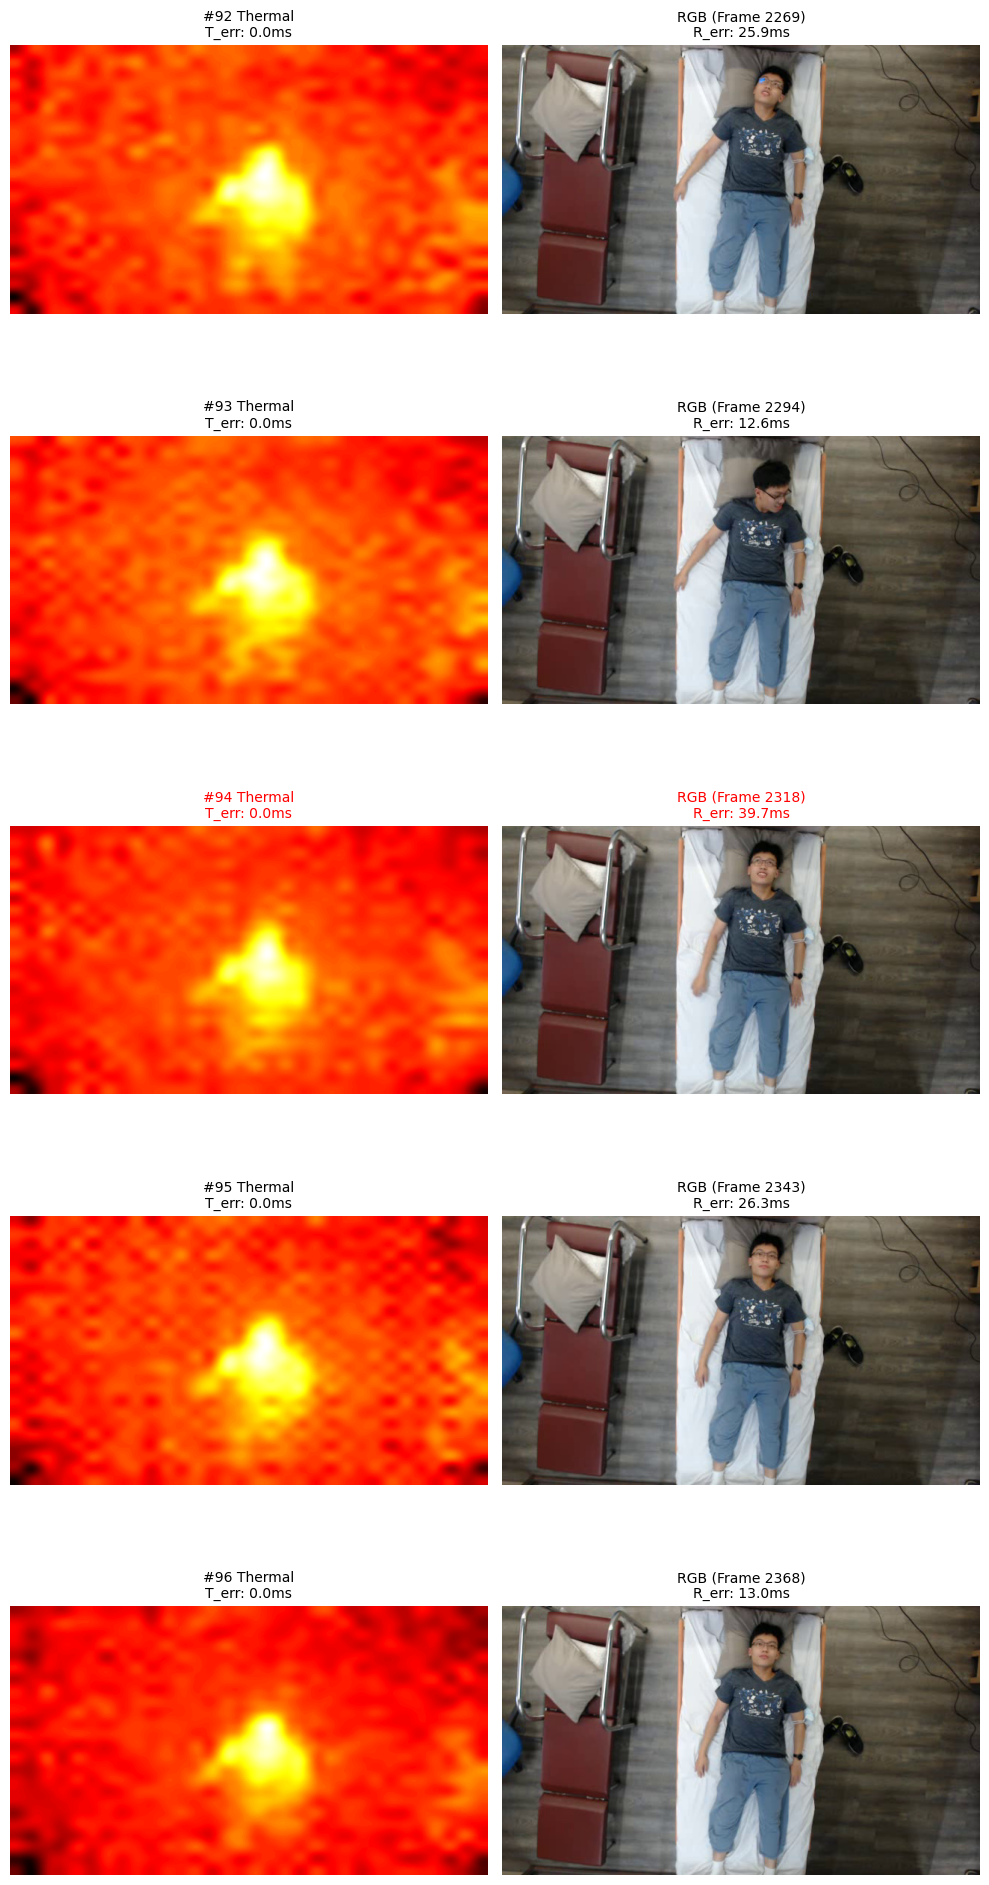


✓ #94 檢查圖已存至: output/synchronized_fixed/pair_94_check.png


In [6]:
# 視覺化 #94 前後的配對
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

check_indices = [92, 93, 94, 95, 96]

for plot_idx, data_idx in enumerate(check_indices):
    if data_idx >= len(meta_df):
        continue
    
    row = meta_df.iloc[data_idx]
    pair_id = row['pair_id']
    
    thermal = np.load(SYNCHRONIZED_DIR / 'thermal' / f"{pair_id}_thermal.npy")
    rgb = np.load(SYNCHRONIZED_DIR / 'rgb' / f"{pair_id}_rgb.npy")
    
    thermal_up = cv2.resize(thermal, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # 應用翻轉（如果需要）
    if FLIP_THERMAL:
        thermal_up = cv2.flip(thermal_up, 1)
    if FLIP_RGB:
        rgb = cv2.flip(rgb, 1)
    
    axes[plot_idx, 0].imshow(thermal_up, cmap='hot')
    axes[plot_idx, 0].set_title(
        f'#{data_idx} Thermal\nT_err: {row["thermal_error_ms"]:.1f}ms',
        fontsize=10,
        color='red' if data_idx == 94 else 'black'
    )
    axes[plot_idx, 0].axis('off')
    
    axes[plot_idx, 1].imshow(rgb)
    axes[plot_idx, 1].set_title(
        f'RGB (Frame {row["rgb_frame_idx"]})\nR_err: {row["rgb_error_ms"]:.1f}ms',
        fontsize=10,
        color='red' if data_idx == 94 else 'black'
    )
    axes[plot_idx, 1].axis('off')

plt.tight_layout()
plt.savefig(FIXED_DIR / 'pair_94_check.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ #94 檢查圖已存至: {FIXED_DIR / 'pair_94_check.png'}")

## Step 3: 重新對齊修復（如果需要）

In [7]:
# 檢查是否需要調整容忍度或重新對齊
print("同步誤差統計:")
print(f"  Thermal - Mean: {meta_df['thermal_error_ms'].mean():.2f}ms, Max: {meta_df['thermal_error_ms'].max():.2f}ms")
print(f"  RGB - Mean: {meta_df['rgb_error_ms'].mean():.2f}ms, Max: {meta_df['rgb_error_ms'].max():.2f}ms")

# 找出高誤差的配對
high_error_threshold = 100  # ms
high_thermal = meta_df[meta_df['thermal_error_ms'] > high_error_threshold]
high_rgb = meta_df[meta_df['rgb_error_ms'] > high_error_threshold]

print(f"\n高誤差配對 (> {high_error_threshold}ms):")
print(f"  Thermal: {len(high_thermal)} 個")
print(f"  RGB: {len(high_rgb)} 個")

if len(high_thermal) > 0:
    print(f"\n  高 Thermal 誤差的配對:")
    for idx, row in high_thermal.head(10).iterrows():
        print(f"    #{idx}: {row['thermal_error_ms']:.2f}ms")

if len(high_rgb) > 0:
    print(f"\n  高 RGB 誤差的配對:")
    for idx, row in high_rgb.head(10).iterrows():
        print(f"    #{idx}: {row['rgb_error_ms']:.2f}ms")

# 判斷是否需要重新對齊
error_rate = (len(high_thermal) + len(high_rgb)) / (2 * len(meta_df)) * 100

print(f"\n整體錯誤率: {error_rate:.2f}%")

if error_rate > 5:
    print("\n⚠️ 建議: 錯誤率較高，建議調整參數後重新對齊")
    print("\n可調整的參數:")
    print("  1. TIMESTAMP_TOLERANCE (當前可能是 62.5ms)")
    print("     建議改為: 31.25ms (更嚴格) 或 93.75ms (更寬鬆)")
    print("  2. 檢查 output.txt 的起始時間是否正確")
else:
    print("\n✓ 錯誤率可接受，主要問題是翻轉")

同步誤差統計:
  Thermal - Mean: 0.00ms, Max: 0.00ms
  RGB - Mean: 19.81ms, Max: 40.13ms

高誤差配對 (> 100ms):
  Thermal: 0 個
  RGB: 0 個

整體錯誤率: 0.00%

✓ 錯誤率可接受，主要問題是翻轉


## Step 4: 產生修復後的資料集

In [8]:
# 選項 1: 只修復翻轉，保留所有配對
print("產生修復後的資料集...\n")

fixed_count = 0

for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="處理中"):
    pair_id = row['pair_id']
    
    # 載入原始資料
    thermal = np.load(SYNCHRONIZED_DIR / 'thermal' / f"{pair_id}_thermal.npy")
    rgb = np.load(SYNCHRONIZED_DIR / 'rgb' / f"{pair_id}_rgb.npy")
    
    # 應用翻轉
    if FLIP_THERMAL:
        thermal = cv2.flip(thermal, 1)
    
    if FLIP_RGB:
        rgb = cv2.flip(rgb, 1)
    
    # 儲存
    np.save(FIXED_DIR / 'thermal' / f"{pair_id}_thermal.npy", thermal)
    np.save(FIXED_DIR / 'rgb' / f"{pair_id}_rgb.npy", rgb)
    
    # 同時存成 jpg 方便檢查
    cv2.imwrite(str(FIXED_DIR / 'thermal' / f"{pair_id}_thermal.jpg"), thermal)
    cv2.imwrite(str(FIXED_DIR / 'rgb' / f"{pair_id}_rgb.jpg"), rgb)
    
    fixed_count += 1

# 複製 metadata
meta_df.to_csv(FIXED_DIR / 'metadata.csv', index=False)

print(f"\n✓ 修復完成！")
print(f"  處理了 {fixed_count} 個配對")
print(f"  輸出目錄: {FIXED_DIR}")
print(f"\n翻轉設定:")
print(f"  Thermal 翻轉: {FLIP_THERMAL}")
print(f"  RGB 翻轉: {FLIP_RGB}")

產生修復後的資料集...



處理中: 100%|██████████| 661/661 [00:04<00:00, 143.54it/s]


✓ 修復完成！
  處理了 661 個配對
  輸出目錄: output/synchronized_fixed

翻轉設定:
  Thermal 翻轉: True
  RGB 翻轉: False


## Step 5: 驗證修復結果

驗證修復後的配對...



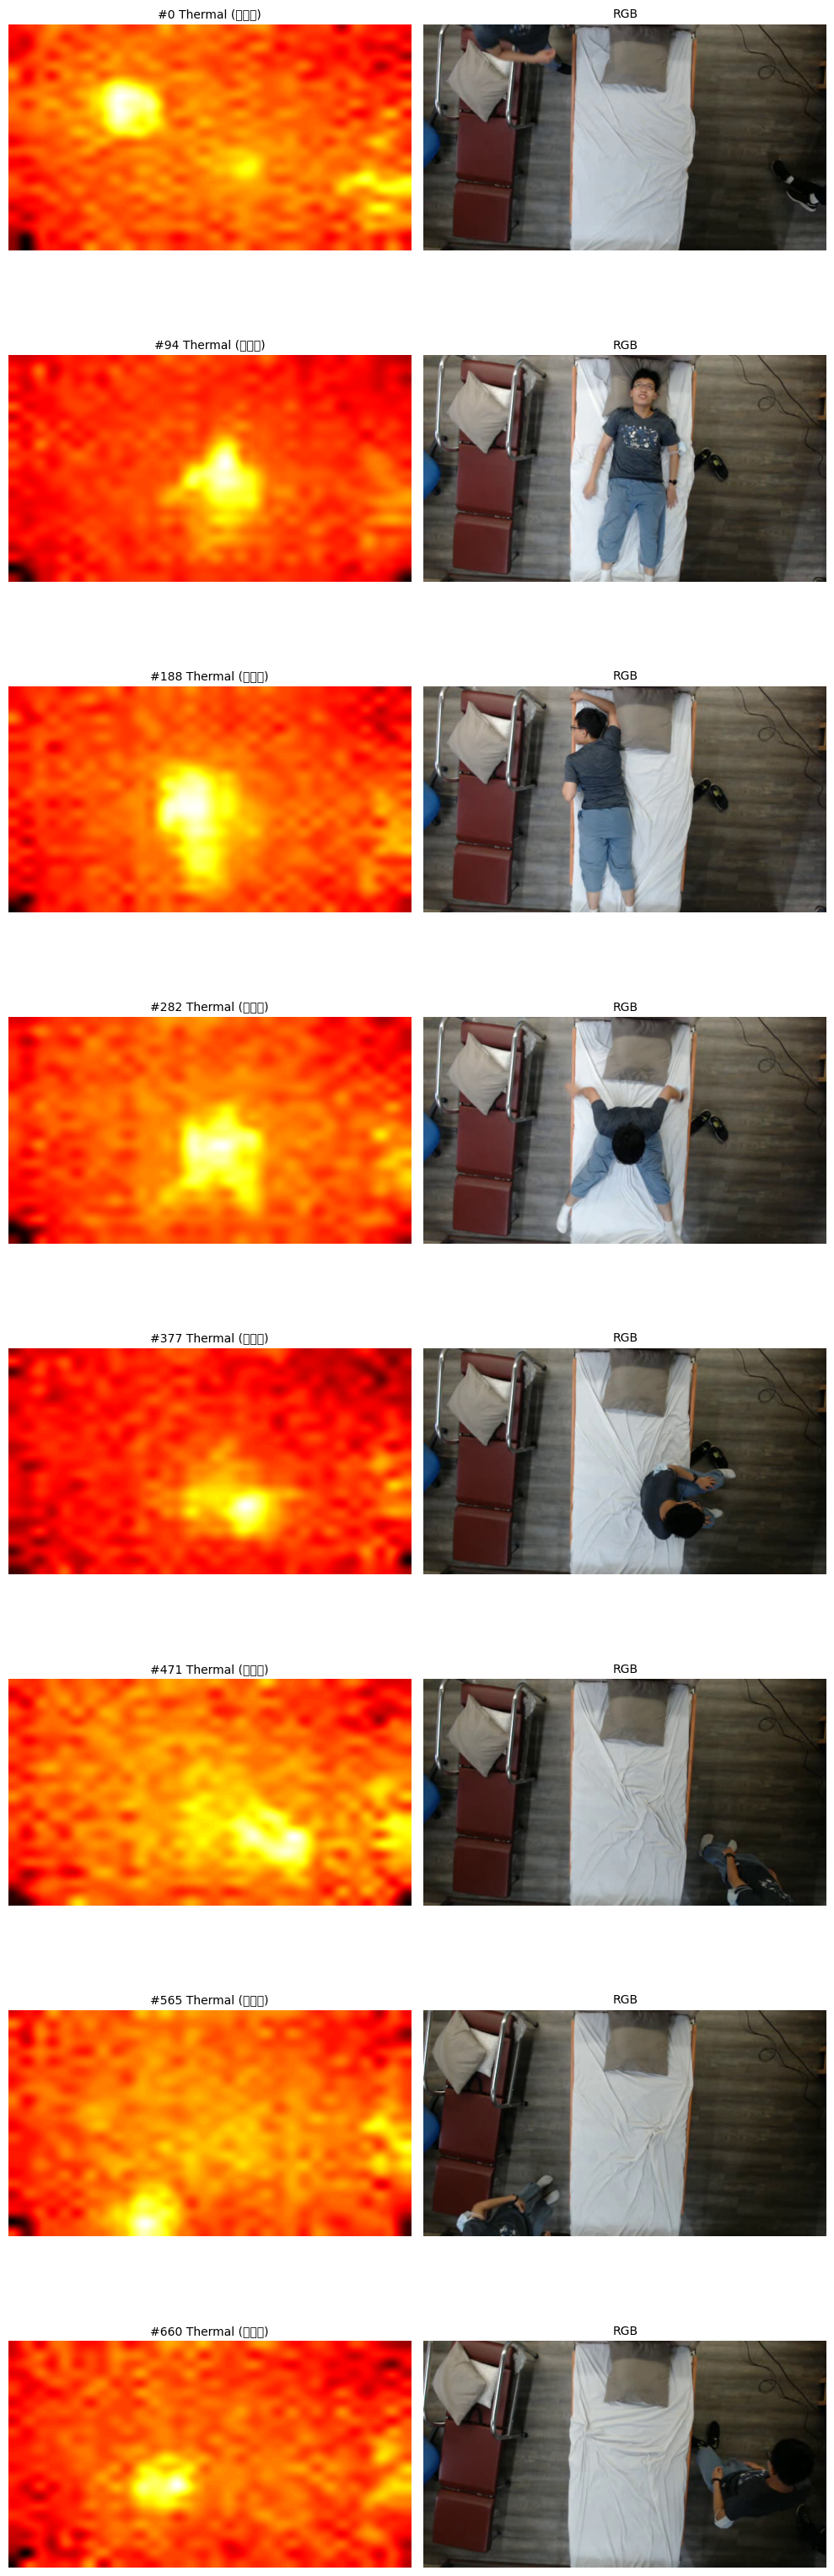


✓ 修復驗證圖已存至: output/synchronized_fixed/fixed_samples_check.png

請檢查上圖，確認:
  1. 左右翻轉問題是否已修復
  2. Thermal 和 RGB 是否對齊


In [9]:
# 再次檢查修復後的結果
print("驗證修復後的配對...\n")

num_samples = 8
sample_indices = np.linspace(0, len(meta_df) - 1, num_samples, dtype=int)

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for plot_idx, data_idx in enumerate(sample_indices):
    row = meta_df.iloc[data_idx]
    pair_id = row['pair_id']
    
    # 載入修復後的資料
    thermal = np.load(FIXED_DIR / 'thermal' / f"{pair_id}_thermal.npy")
    rgb = np.load(FIXED_DIR / 'rgb' / f"{pair_id}_rgb.npy")
    
    thermal_up = cv2.resize(thermal, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    axes[plot_idx, 0].imshow(thermal_up, cmap='hot')
    axes[plot_idx, 0].set_title(f'#{data_idx} Thermal (修復後)', fontsize=10)
    axes[plot_idx, 0].axis('off')
    
    axes[plot_idx, 1].imshow(rgb)
    axes[plot_idx, 1].set_title(f'RGB', fontsize=10)
    axes[plot_idx, 1].axis('off')

plt.tight_layout()
plt.savefig(FIXED_DIR / 'fixed_samples_check.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 修復驗證圖已存至: {FIXED_DIR / 'fixed_samples_check.png'}")
print("\n請檢查上圖，確認:")
print("  1. 左右翻轉問題是否已修復")
print("  2. Thermal 和 RGB 是否對齊")

## Step 6: （可選）移除錯誤配對並重新編號

In [10]:
# 如果確認某些配對是錯的（例如 #94），可以手動移除

# ========== 設定要移除的配對 ==========
REMOVE_INDICES = [94]  # 填入要移除的配對編號，例如 [94, 120, 150]
# ========================================

if len(REMOVE_INDICES) > 0:
    print(f"準備移除 {len(REMOVE_INDICES)} 個錯誤配對: {REMOVE_INDICES}\n")
    
    CLEANED_DIR = Path('./output/synchronized_cleaned')
    CLEANED_DIR.mkdir(parents=True, exist_ok=True)
    (CLEANED_DIR / 'thermal').mkdir(exist_ok=True)
    (CLEANED_DIR / 'rgb').mkdir(exist_ok=True)
    
    # 過濾 metadata
    meta_cleaned = meta_df.drop(REMOVE_INDICES).reset_index(drop=True)
    
    print(f"原始配對數: {len(meta_df)}")
    print(f"清理後配對數: {len(meta_cleaned)}")
    
    # 重新編號並複製檔案
    for new_idx, old_idx in enumerate(tqdm(meta_cleaned.index, desc="重新編號")):
        old_row = meta_df.iloc[old_idx]
        old_pair_id = old_row['pair_id']
        new_pair_id = f"pair_{new_idx:05d}"
        
        # 載入修復後的資料
        thermal = np.load(FIXED_DIR / 'thermal' / f"{old_pair_id}_thermal.npy")
        rgb = np.load(FIXED_DIR / 'rgb' / f"{old_pair_id}_rgb.npy")
        
        # 用新編號儲存
        np.save(CLEANED_DIR / 'thermal' / f"{new_pair_id}_thermal.npy", thermal)
        np.save(CLEANED_DIR / 'rgb' / f"{new_pair_id}_rgb.npy", rgb)
        
        cv2.imwrite(str(CLEANED_DIR / 'thermal' / f"{new_pair_id}_thermal.jpg"), thermal)
        cv2.imwrite(str(CLEANED_DIR / 'rgb' / f"{new_pair_id}_rgb.jpg"), rgb)
        
        # 更新 metadata
        meta_cleaned.at[new_idx, 'pair_id'] = new_pair_id
    
    # 儲存新的 metadata
    meta_cleaned.to_csv(CLEANED_DIR / 'metadata.csv', index=False)
    
    print(f"\n✓ 清理完成！")
    print(f"  輸出目錄: {CLEANED_DIR}")
    print(f"  最終配對數: {len(meta_cleaned)}")
else:
    print("未設定要移除的配對，跳過此步驟")

準備移除 1 個錯誤配對: [94]

原始配對數: 661
清理後配對數: 660


重新編號: 100%|██████████| 660/660 [00:04<00:00, 143.17it/s]


✓ 清理完成！
  輸出目錄: output/synchronized_cleaned
  最終配對數: 660


## 總結報告

In [11]:
print("\n" + "="*70)
print("修復總結報告")
print("="*70)

print(f"\n1. 原始資料: {SYNCHRONIZED_DIR}")
print(f"   配對數: {len(meta_df)}")

print(f"\n2. 修復後資料: {FIXED_DIR}")
print(f"   配對數: {len(meta_df)}")
print(f"   Thermal 翻轉: {FLIP_THERMAL}")
print(f"   RGB 翻轉: {FLIP_RGB}")

if len(REMOVE_INDICES) > 0:
    print(f"\n3. 清理後資料: {CLEANED_DIR}")
    print(f"   配對數: {len(meta_cleaned)}")
    print(f"   移除的配對: {REMOVE_INDICES}")
    print(f"\n   👉 建議使用此目錄訓練 SR 模型")
else:
    print(f"\n3. 未執行清理步驟")
    print(f"\n   👉 建議使用 {FIXED_DIR} 訓練 SR 模型")

print("\n" + "="*70)
print("修復完成！")
print("="*70)

print("\n後續步驟:")
print("1. 檢查修復驗證圖: fixed_samples_check.png")
print("2. 如果滿意，將修復後的資料路徑更新到訓練 notebook")
print("3. 執行 thermal_super_resolution.ipynb 訓練模型")


修復總結報告

1. 原始資料: output/synchronized
   配對數: 661

2. 修復後資料: output/synchronized_fixed
   配對數: 661
   Thermal 翻轉: True
   RGB 翻轉: False

3. 清理後資料: output/synchronized_cleaned
   配對數: 660
   移除的配對: [94]

   👉 建議使用此目錄訓練 SR 模型

修復完成！

後續步驟:
1. 檢查修復驗證圖: fixed_samples_check.png
2. 如果滿意，將修復後的資料路徑更新到訓練 notebook
3. 執行 thermal_super_resolution.ipynb 訓練模型
